# <p style="background-color:#C2586E;color:white;font-size:100%;text-align:center;border-radius:10px 10px;">Dome_Predictive Maintenance using audio</p>

**Task:**

    Our task is to identify through sound which part of the machine is faulty. This helps us find and fix it quickly.


**Bearing**
    The goal is to design a predictive maintenance system by predicting the occurrence of defects in motors using the noise emitted by the motors to determine the type of problem. There are 3 types of defects:
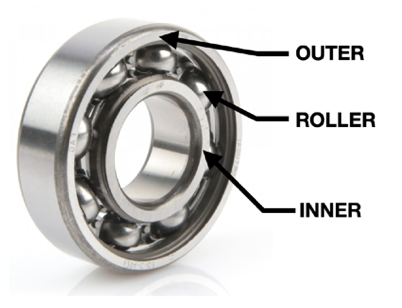

**Dataset:**
    
    Industrial Dataset Specifications:
    During the experiments, bearingvibrationswere sampled every10sat25,600Hzfor0.1s. Samplingatsuchahigh frequencyinindustrialapplicationsmaynotbefeasible. So, wedownsampledthe rawvibrationsignal of 25,600Hz in theFEMTOdatasetbyhalfto12,800Hz
    
    we obtain frequencies up to 10000hz
    
    https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/
    
   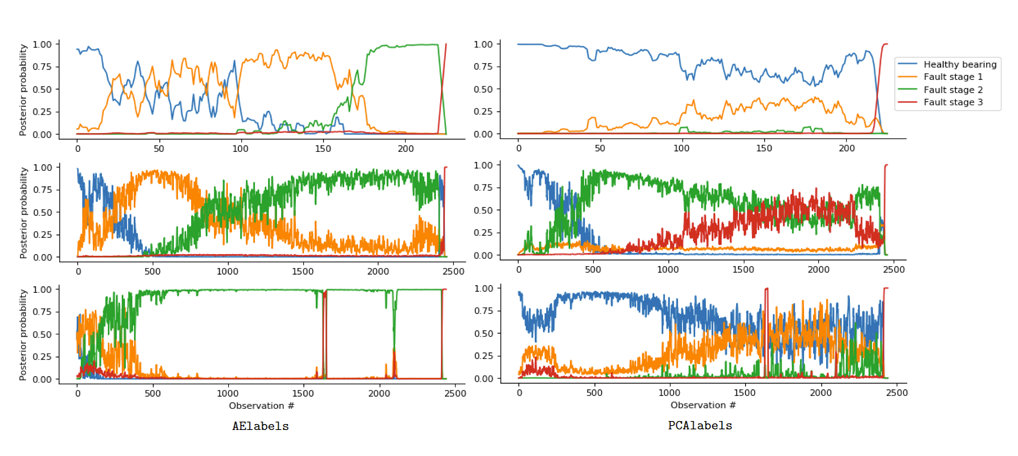

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt
from scipy import io, misc
import scipy
import tensorflow as tf
import glob
from PIL import Image
import os
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.optimizers import Adam
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from keras.preprocessing.image import ImageDataGenerator
import random
import keras.backend as K
import keras
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

### **Data_Bearing**

Every sample will be 0.2 seconds long and is recorded at a 10000Hz frequency.

In [ ]:
duration_samples = 0.2 #seconds
size_max = 120000
frequence = 10000 #Hertz

### Loading

In [ ]:
file = "../input/engine-acoustic-emissions/dataset.mat"

dataset = scipy.io.loadmat(file)

df_normal = dataset["normal"].reshape(-1)[:size_max]
df_inner = dataset["inner"].reshape(-1)[:size_max]
df_roller = dataset["roller"].reshape(-1)[:size_max]
df_outer = dataset["outer"].reshape(-1)[:size_max]

data = [df_normal,df_inner,df_roller,df_outer]

In [ ]:
def load_data(train=0.7):
    type_track = 0
    n_samples_each = int(size_max/frequence/duration_samples)
    audios_train = []
    audios_test = []
    number_train=int(n_samples_each*0.7)

    for track in data:
        for i in range(0,n_samples_each):
            t1 = int(i*frequence*duration_samples)
            t2 = int((i+1)*frequence*duration_samples)
            new = list(track)[t1:t2]
            if i<number_train:
                audios_train.append((type_track,new))
            else:
                audios_test.append((type_track,new))
        type_track = type_track+1
    np.random.seed(1)
    np.random.shuffle(audios_train)
    np.random.seed(1)
    np.random.shuffle(audios_test)
    return [i[1] for i in audios_train], [i[1] for i in audios_test], [i[0] for i in audios_train], [i[0] for i in audios_test]

In [ ]:
audios_train, audios_test, label_train, label_test = load_data()

### The audios

In [ ]:
IPython.display.Audio(df_normal, rate=frequence)

In [ ]:
IPython.display.Audio(df_inner, rate=frequence)

In [ ]:
IPython.display.Audio(df_roller, rate=frequence)

In [ ]:
IPython.display.Audio(df_outer, rate=frequence)

In [ ]:
plt.figure(figsize=(15,5))
lplt.waveshow(df_normal[:1000], sr=frequence)
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
lplt.waveshow(df_inner[:1000], sr=frequence)
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
lplt.waveshow(df_roller[:1000], sr=frequence)
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
lplt.waveshow(df_outer[:1000], sr=frequence)
plt.show()

> 📌 Now we have for the traning and test data a list of arrays giving the sound for the period of the sample.

# CNN_MODEL

 **【Visualize audio】 convert audio to images**

To use this method, I will first generate an image representation of every sounds. For that I will use different type of graph representations such as amplitude graphs, spectral contrasts graphs, chroma graphs, etc.

Those different graphs are created using different maths techniques wavelet transforms for example.

In [ ]:
def processing_images(audios_train,audios_test):
    mels_train = []
    for audio in audios_train:
        n_fft = 2048 # window size
        hop_length = 512 # window hop length for STFT

        #计算音频的短时傅里叶变换
        #Compute the short-time Fourier transform of audio
        fig, ax = plt.subplots(figsize=(3, 2))
        stft = librosa.stft(np.asarray(audio), n_fft=n_fft, hop_length=hop_length)
        lplt.specshow(stft, sr=frequence, x_axis='time', y_axis='hz');
        plt.axis('off');
        fig.canvas.draw()
        data1 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data1 = data1.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        
        #-分贝中的参考点(0 dB)可以自由选择。librosa.amplitude_to_db的缺省值是计算numpy.max，
        #这意味着输入的最大值将映射到0 dB。所有其他值都将为负值。该函数还对声音范围应用了一个阈值，默认为80 dB。所以任何低于-80 dB的东西都会被剪裁-80 dB。
        #-Negative mapping，We will map the maximum value to 0, and other values are negative
        
        fig, ax = plt.subplots(figsize=(3, 2))
        stft_db = librosa.amplitude_to_db(stft, ref=np.max)
        lplt.specshow(stft_db, sr=frequence, x_axis='time', y_axis='hz', cmap='cool');
        plt.axis('off');
        fig.canvas.draw()
        data2 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data2 = data2.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        #-将STFT表示转换为幅度和相位表示
        #-Convert STFT representation to amplitude and phase representation
        fig, ax = plt.subplots(figsize=(3, 2))
        S,phase = librosa.magphase(librosa.stft(np.asarray(audio)))
        spectral = librosa.feature.spectral_contrast(S=S,sr=frequence,fmin=30)
        lplt.specshow(spectral, sr=frequence, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool');
        plt.axis('off');
        fig.canvas.draw()
        data3 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data3 = data3.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        #-Calculate the chromaticity distribution represented by STFT
        #-计算STFT表示的色度分布
        fig, ax = plt.subplots(figsize=(3, 2))
        chroma = librosa.feature.chroma_stft(np.asarray(audio), sr=frequence)
        lplt.specshow(chroma, sr=frequence, x_axis='time', y_axis='chroma', cmap='coolwarm');
        plt.axis('off');
        fig.canvas.draw()
        data4 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data4 = data4.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        # Calculate MFCC
        #-1）先对语音进行预加重、分帧和加窗；
        # pre-emphasize, frame and window the speech;
        #-2）对每一个短时分析窗，通过FFT得到对应的频谱；
        # For each short-term analysis window, obtain the corresponding spectrum through FFT;
        #-3）将上面的频谱通过Mel滤波器组得到Mel频谱；
        # Pass the above spectrum through the Mel filter bank to obtain the Mel spectrum;
        #-4）在Mel频谱上面进行倒谱分析（取对数，做逆变换，实际逆变换一般是通过DCT离散余弦变
        # Perform cepstral analysis on the Mel spectrum 
        fig, ax = plt.subplots(figsize=(3, 2))
        mfccs = librosa.feature.mfcc(y=np.asarray(audio), sr=frequence, n_mfcc=20)
        lplt.specshow(mfccs, x_axis='time');
        plt.axis('off');
        fig.canvas.draw()
        data5 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data5 = data5.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        mels_train.append(np.concatenate((data1,data2,data3,data4,data5),axis=0).reshape(720, 216, 3))

    mels_test = []
    for audio in audios_test:
        n_fft = 2048 # window size
        hop_length = 512 # window hop length for STFT

        fig, ax = plt.subplots(figsize=(3, 2))
        stft = librosa.stft(np.asarray(audio), n_fft=n_fft, hop_length=hop_length)
        lplt.specshow(stft, sr=frequence, x_axis='time', y_axis='hz');
        plt.axis('off');
        fig.canvas.draw()
        data1 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data1 = data1.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        fig, ax = plt.subplots(figsize=(3, 2))
        stft_db = librosa.amplitude_to_db(stft, ref=np.max)
        lplt.specshow(stft_db, sr=frequence, x_axis='time', y_axis='hz', cmap='cool');
        plt.axis('off');
        fig.canvas.draw()
        data2 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data2 = data2.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        fig, ax = plt.subplots(figsize=(3, 2))
        S,phase = librosa.magphase(librosa.stft(np.asarray(audio)))
        spectral = librosa.feature.spectral_contrast(S=S,sr=frequence,fmin=30)
        lplt.specshow(spectral, sr=frequence, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool');
        plt.axis('off');
        fig.canvas.draw()
        data3 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data3 = data3.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        fig, ax = plt.subplots(figsize=(3, 2))
        chroma = librosa.feature.chroma_stft(np.asarray(audio), sr=frequence)
        lplt.specshow(chroma, sr=frequence, x_axis='time', y_axis='chroma', cmap='coolwarm');
        plt.axis('off');
        fig.canvas.draw()
        data4 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data4 = data4.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        
        fig, ax = plt.subplots(figsize=(3, 2))
        mfccs = librosa.feature.mfcc(y=np.asarray(audio), sr=frequence, n_mfcc=20)
        lplt.specshow(mfccs, x_axis='time');
        plt.axis('off');
        fig.canvas.draw()
        data5 = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data5 = data5.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        mels_test.append(np.concatenate((data1,data2,data3,data4,data5),axis=0).reshape(720, 216, 3))
        
    return mels_train, mels_test

In [ ]:
mels_train, mels_test = processing_images(audios_train,audios_test);

In the end, we get different a 5-graphs picture for every sound that we will use in the CNN to predict the defect.

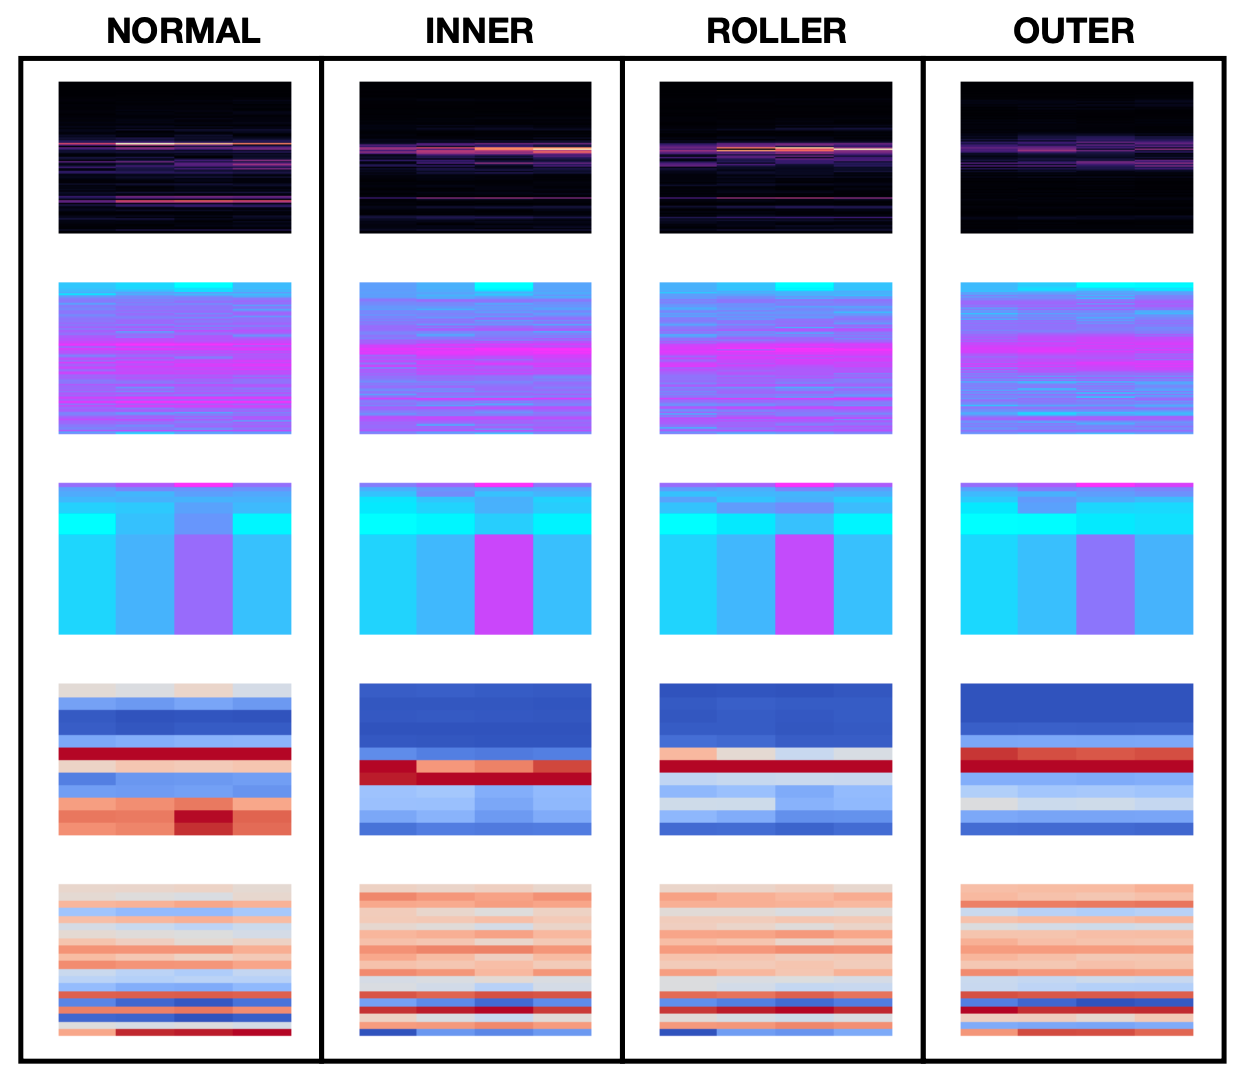

Now we define the CNN model.

In [ ]:
def CNNModel(input_shape,classes=4):
    X_input = Input(input_shape)
    
    X = Conv2D(4,kernel_size=(3,3),strides=(1,1))(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(8,kernel_size=(3,3),strides=(1,1))(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(16,kernel_size=(3,3),strides = (1,1))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(32,kernel_size=(3,3),strides = (1,1))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Conv2D(64,kernel_size=(3,3),strides=(1,1))(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)
    
    X = Conv2D(128,kernel_size=(3,3),strides=(1,1))(X)
    X = BatchNormalization(axis=-1)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2))(X)

    X = Flatten()(X)

    X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)

    model = Model(inputs=X_input,outputs=X,name='GenreModel')

    return model

Binary classification

Next We can binarize the different labels to have the good inputs for the model.

In [ ]:
lb = preprocessing.LabelBinarizer()
y_training = lb.fit_transform(label_train)

In [ ]:
def get_precision(y_true, y_pred): #taken from old keras source code  旧版
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def get_f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
  
model = CNNModel(input_shape=(720, 216, 3),classes=4)
opt = Adam(learning_rate=0.005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=["accuracy",get_f1]) 
history = model.fit(x=np.asarray(mels_train), y=np.asarray(y_training),epochs=30, validation_split=0.2,shuffle=True,batch_size=len(mels_train),verbose=1)

In [ ]:
fig = plt.figure(figsize=(16,10))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')


plt.subplot(2, 2, 2)
plt.plot(history.history['get_f1'])
plt.plot(history.history['val_get_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)